In [199]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette("hls", 10)
import os
import lasagne

%load_ext autoreload
%autoreload 2

import pickle

from braindecode.experiments.load import load_exp_and_model
from braindecode.analysis.plot_util import plot_head_signals_tight,plot_head_signals

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
%cd '/home/hartmank/braindecode/convvisual'
import analysis
import utils

/home/hartmank/braindecode/convvisual


In [3]:
modelpath = 'models/paper/ours/cnt/deep4/243'
#modelpath = 'models/paper/ours/cnt/deep4/car/22'
#savepath = os.path.join(modelpath,'%dBestInputsFor%dBestFilters/'%(50,5))
savepath = os.path.join(modelpath,'%dBestInputsFor%dBestFilters_FilterActDiff/'%(30,5))
exp, model = load_exp_and_model(os.path.join('../data/',modelpath), set_invalid_to_NaN=False)

sensor_names = exp.dataset.test_set.sensor_names
#sensor_names.remove('Cz')

sampling_rate = exp.dataset.train_set.signal_processor.cnt_preprocessors[1][1]['newfs']
step = 1./sampling_rate

n_chans = lasagne.layers.get_all_layers(model)[0].shape[1]

INFO:braindecode.experiments.experiment:Setting n_sample preds automatically to 479
INFO:braindecode.experiments.experiment:Input window length is 522
INFO:braindecode.experiments.experiment:Setting n_sample preds automatically to 479
INFO:braindecode.experiments.experiment:Input window length is 522


In [82]:
get_ipython().magic(u"cd '/home/hartmank/braindecode'")
datasets = exp.dataset_provider.get_train_merged_valid_test(exp.dataset)
exp.iterator.batch_size = 9999999
exp.iterator.input_time_length = 522
test_batches = list(exp.iterator.get_batches(datasets['test'], shuffle=False))
inputs_t,targets_t = test_batches[0]
inputs_t = inputs_t.squeeze()

/home/hartmank/braindecode


3

### Load RF data of 5 best filters and their best inputs for certain class and layer

In [257]:
cl = 1
lay = 28
savepath= os.path.join('/home/hartmank/data/convvisual/RF_data',savepath)
data28C0 = utils.load_data(os.path.join(savepath,'Class%d_Layer%d.data'%(cl,lay)))
X_Y_data = utils.load_data(os.path.join(savepath,'X_Y_Data.data'))
#X_Y_data = data28C0

In [258]:
targets = targets_t.reshape((len(inputs_t),-1,4))
targets = targets.sum(axis=1).argmax(axis=1)
#print targets==0
inputs = inputs_t[targets.T==cl]

In [259]:
X_RF_cropped,Input_baseline = utils.get_cropped_RF_and_baseline(data28C0,X_Y_data,([0],[1],n_chans,-1))

(4, 30, 44, 522)


In [260]:
print X_RF_cropped.shape,Input_baseline.shape
if len(Input_baseline)>1000:
    Input_baseline = Input_baseline[:1000]

(4, 30, 44, 522) (574, 44, 522)


In [261]:
inputs_t.shape

(320, 44, 522)

In [286]:
#ind = np.
#X_RF_cropped = np.asarray([list(inputs_t.squeeze()[targets.T==cl])])
Input_baseline = inputs_t[targets.T!=cl]

### Extract features from signals

In [287]:
feature_funcs = (analysis.get_frequency,analysis.get_frequency_change,analysis.get_offset,analysis.get_offset_change)
filt = 0
Input_data = analysis.bootstrap_resample(Input_baseline,1000)
FFT_base,FFTc_base,mean_base,meanc_base = utils.get_feature_vals(Input_data,feature_funcs,sampling_rate=sampling_rate)

In [288]:
FFT_base = np.asarray(FFT_base.T[0].tolist())
FFTc_base = np.asarray(FFTc_base.T[0].tolist())

In [289]:
print FFT_base.shape

(1000, 44, 261)


In [290]:
filt = 0
X_RF_data = analysis.bootstrap_resample(X_RF_cropped[filt],1000)
FFT,FFTc,mean,meanc = utils.get_feature_vals(X_RF_data,feature_funcs,sampling_rate=sampling_rate)
freqs_FFT = FFT.T[2][0]
freqs_FFTc = FFTc.T[2][0]

In [291]:
FFT = np.asarray(FFT.T[0].tolist())
FFTc = np.asarray(FFTc.T[0].tolist())
FFT.shape

(1000, 44, 261)

In [292]:
print FFT.shape,mean.shape

(1000, 44, 261) (1000, 44)


### Compute median and median deviations for features
Frequency spectrum

Difference of frequency spectrum in first and second half of signal

Mean amplitude

Difference of mean amplitude in first and second half

In [293]:
(feat_means,feat_stds),b,names = analysis.feature_distributions([FFT,FFTc,mean,meanc],['FFT','FFTc','Mean','Meanc'])
feat_stds = np.asarray(feat_stds)
feat_means = np.asarray(feat_means)

(feat_means_base,feat_stds_base),b,names = analysis.feature_distributions([FFT_base,FFTc_base,mean_base,meanc_base],['FFT','FFTc','Mean','Meanc'])
feat_stds_base = np.asarray(feat_stds_base)
feat_means_base = np.asarray(feat_means_base)

names = np.asarray(names)

Make sure this is tested!!
a (1000, 44, 261)
a (1000, 44, 130)
a (1000, 44)
a (1000, 44)
Make sure this is tested!!
a (1000, 44, 261)
a (1000, 44, 130)
a (1000, 44)
a (1000, 44)


In [294]:
print feat_means.shape,feat_means_base.shape

(17292,) (17292,)


### Compare feature distributions and order them

In [295]:
feat_std_diff = np.divide(feat_stds_base,feat_stds)
sort_std_diff = feat_std_diff.argsort()[::-1]

# This mean difference seems to deliver the most expressive results
feat_mean_diff = np.abs(np.divide(feat_means_base-feat_means,feat_stds_base))
sort_mean_diff = feat_mean_diff.argsort()[::-1]

#rank = np.sqrt(np.power(feat_std_diff,2)+np.power(sort_mean_diff,2))
#sort_rank = rank.argsort()[::-1]

### Overview of sensor names and frequencies with their corresponding indeces used in feature list

In [296]:
print np.asarray(['%d: %s'%(i,s) for i,s in enumerate(sensor_names)])
print np.asarray(['%d: %s'%(i,fr) for i,fr in enumerate(freqs_FFT)])

['0: FFC5h' '1: FFC3h' '2: FFC1h' '3: FFC2h' '4: FFC4h' '5: FFC6h' '6: FC5'
 '7: FC3' '8: FC1' '9: FCz' '10: FC2' '11: FC4' '12: FC6' '13: FCC5h'
 '14: FCC3h' '15: FCC1h' '16: FCC2h' '17: FCC4h' '18: FCC6h' '19: C5'
 '20: C3' '21: C1' '22: Cz' '23: C2' '24: C4' '25: C6' '26: CCP5h'
 '27: CCP3h' '28: CCP1h' '29: CCP2h' '30: CCP4h' '31: CCP6h' '32: CP5'
 '33: CP3' '34: CP1' '35: CPz' '36: CP2' '37: CP4' '38: CP6' '39: CPP5h'
 '40: CPP3h' '41: CPP1h' '42: CPP2h' '43: CPP4h' '44: CPP6h']
['0: 0.0' '1: 0.478927203065' '2: 0.95785440613' '3: 1.4367816092'
 '4: 1.91570881226' '5: 2.39463601533' '6: 2.87356321839'
 '7: 3.35249042146' '8: 3.83141762452' '9: 4.31034482759'
 '10: 4.78927203065' '11: 5.26819923372' '12: 5.74712643678'
 '13: 6.22605363985' '14: 6.70498084291' '15: 7.18390804598'
 '16: 7.66283524904' '17: 8.14176245211' '18: 8.62068965517'
 '19: 9.09961685824' '20: 9.5785440613' '21: 10.0574712644'
 '22: 10.5363984674' '23: 11.0153256705' '24: 11.4942528736'
 '25: 11.9731800766' '26

### Names of the ordered features
Feature_channel(_featureentry e.g. frequency)

In [297]:
print feat_mean_diff[sort_mean_diff[:10]]

[ 1.24835817  1.23836865  1.1852005   1.16058052  1.1009879   1.06018426
  1.0351185   1.02779489  1.00769409  0.99636722]


In [221]:
print names[sort_mean_diff].tolist()

['Meanc_16', 'Meanc_10', 'Meanc_27', 'Meanc_33', 'Meanc_39', 'Meanc_15', 'FFT_23_118', 'Meanc_20', 'FFT_10_29', 'FFT_17_107', 'FFTc_41_1', 'Meanc_42', 'Meanc_38', 'Meanc_9', 'FFT_17_66', 'FFT_31_180', 'FFTc_17_25', 'FFT_16_29', 'Meanc_31', 'Meanc_24', 'FFTc_29_13', 'FFT_33_2', 'FFTc_27_1', 'Meanc_40', 'FFT_40_166', 'FFTc_40_1', 'FFT_21_93', 'FFTc_8_1', 'FFTc_42_1', 'Meanc_25', 'Meanc_36', 'FFTc_28_1', 'FFT_39_74', 'FFTc_2_1', 'FFTc_22_13', 'FFT_16_1', 'FFTc_22_24', 'Meanc_43', 'Meanc_30', 'FFT_43_167', 'FFT_27_178', 'FFTc_39_1', 'FFTc_11_25', 'Meanc_41', 'FFT_27_1', 'FFT_41_133', 'FFTc_17_24', 'FFT_37_140', 'FFTc_26_15', 'FFT_4_163', 'FFT_37_0', 'FFTc_1_103', 'FFT_42_155', 'FFT_16_150', 'FFT_18_137', 'Meanc_28', 'FFT_30_121', 'Mean_4', 'FFT_33_137', 'Meanc_23', 'FFT_36_120', 'Meanc_19', 'FFTc_27_52', 'FFTc_29_15', 'FFT_43_155', 'FFTc_29_24', 'FFT_10_91', 'FFT_39_96', 'FFTc_27_100', 'FFTc_32_22', 'FFT_10_1', 'FFTc_18_65', 'FFTc_26_33', 'Meanc_6', 'FFT_17_203', 'FFT_33_143', 'FFTc_33_33'

### Plot of all signals of specific channel and mean (red)
Top: Optimal inputs for layer and class

Bottom: Arbitrary inputs

(30, 522)


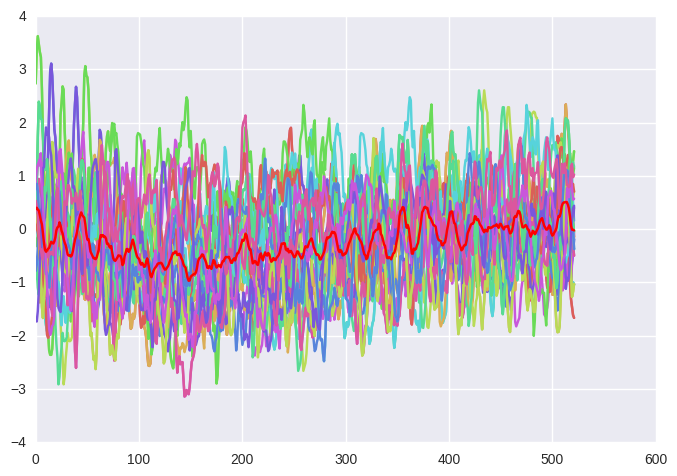

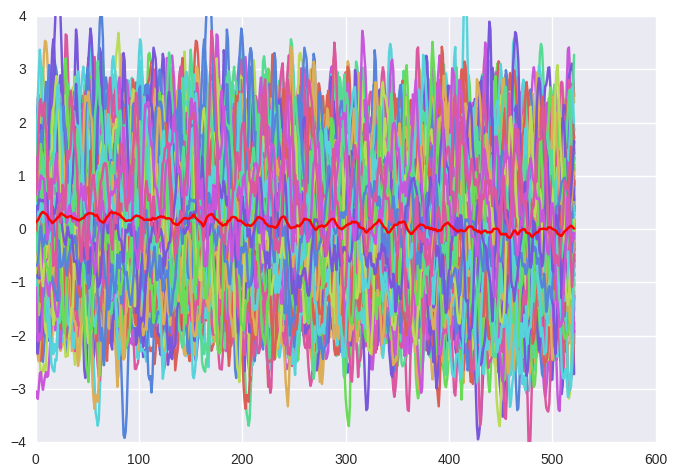

In [124]:
chan = 10
print X_RF_cropped[filt,:,chan].shape
plt.plot(X_RF_cropped[filt,:,chan].T)
plt.plot(X_RF_cropped[filt,:,chan].T.mean(axis=1),'red')
limits = plt.gca().get_ylim()
plt.show()

plt.plot(Input_baseline[:,chan].T)
plt.plot(Input_baseline[:,chan].T.mean(axis=1),'red')
plt.ylim(limits)
plt.show()

### Mean amplitude of specific channel
Top: Optimal inputs

Bottom: Arbitrary inputs

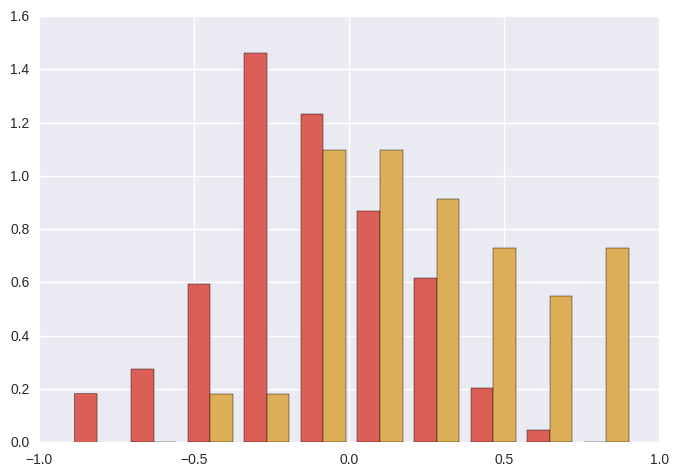

In [398]:
chan=37
h = plt.hist([mean_base[:,chan],mean[:,chan]],normed=True)
plt.show()

### Frequency spectrum of specific channel
Top: Optimal inputs

Bottom: Arbitrary inputs

6.30907980182


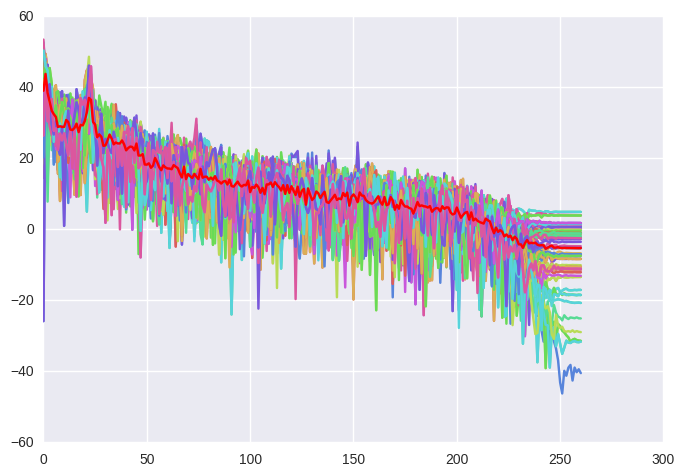

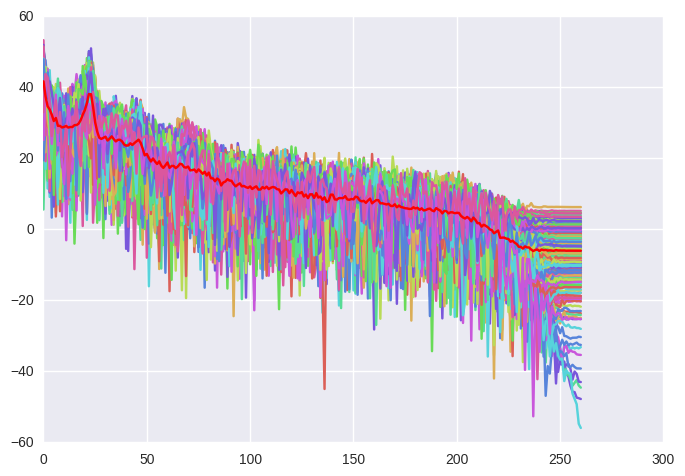

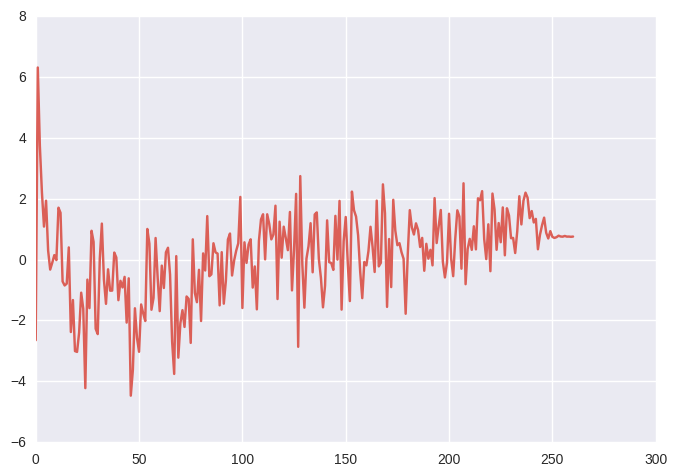

In [55]:
chan = 39
freq = 1
print np.median(FFT[:,chan],axis=0)[freq]-np.median(FFT_base[:,chan],axis=0)[freq]
X = range(FFT.shape[2])
plt.plot(X,FFT[:,chan].T)
plt.plot(X,np.median(FFT[:,chan],axis=0).T,'red')
limits = plt.gca().get_ylim()
plt.show()
plt.plot(X,FFT_base[:,chan].T)
plt.plot(X,np.median(FFT_base[:,chan],axis=0).T,'red')
plt.ylim(limits)
plt.show()

plt.plot(X,(np.median(FFT[:,chan],axis=0)-np.median(FFT_base[:,chan],axis=0)).T)
plt.show()

### Change of mean amplitude of specific channel
Top: Optimal inputs

Bottom: Arbitrary inputs

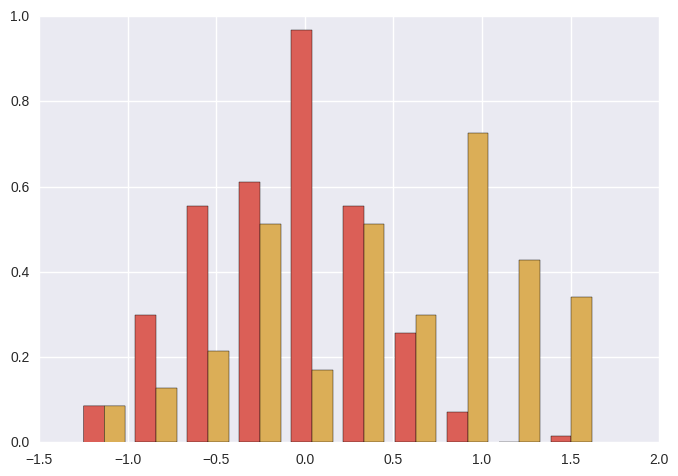

In [62]:
chan=15
h = plt.hist([meanc_base[:,chan],meanc[:,chan]],normed=True)
plt.show()

### Change of frequency spectrum of specific channel
Top: Optimal inputs

Bottom: Arbitrary inputs

-2.7822378624


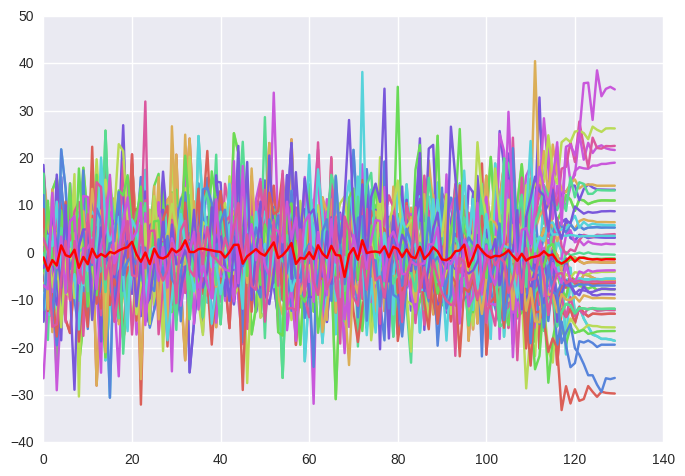

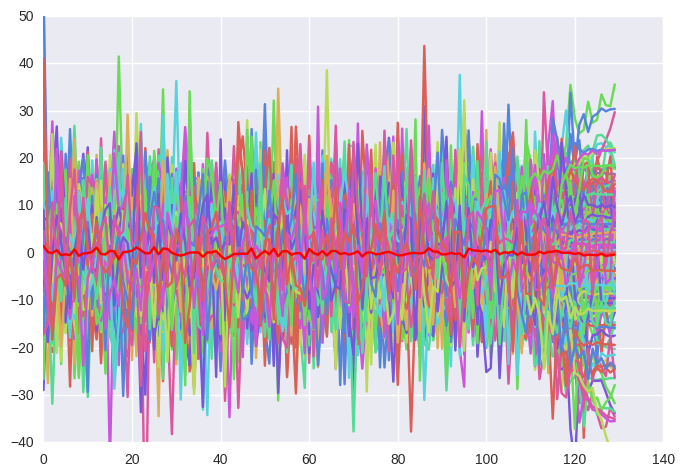

In [106]:
chan = 30
freq = 68
print np.median(FFT[:,chan],axis=0)[freq]-np.median(FFT_base[:,chan],axis=0)[freq]
plt.plot(FFTc[:,chan].T)
plt.plot(FFTc[:,chan].mean(axis=0).T,'red')
limits = plt.gca().get_ylim()
plt.show()
plt.plot(FFTc_base[:,chan].T)
plt.plot(FFTc_base[:,chan].mean(axis=0).T,'red')
plt.ylim(limits)
plt.show()

In [164]:
data28C0['Units'][0].shape

(50, 4)